In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Config
SAMPLING_RATE = 0.5     # Taxa de amostragem em segundos (nao sabemos se é isso ainda)
N_CLUSTERS = 2          # Número de clusters desejados

PESSOA_INICIAL = 3      # Começar com a pessoa 3 (exemplo)

In [14]:
def carregar_dados_pessoa(pessoa_id):
    """
    
    Carrega dados de acelerômetro e giroscópio de uma pessoa específica
    
    Args:
        pessoa_id: ID da pessoa (número)
    
    Returns:
        tuple: (DataFrame acelerômetro, DataFrame giroscópio)
    """
    # Caminhos dos arquivos
    accel_file = f'acelerometro/acelerometro_{pessoa_id}.csv'
    
    # O giroscópio tem nomenclatura diferente para pessoa 3
    if pessoa_id == 3:
        gyro_file = f'giroscopio/giroscopio_{pessoa_id}-1.txt'
    else:
        gyro_file = f'giroscopio/giroscopio_{pessoa_id}.txt'
    
    # Carregar acelerômetro (CSV com cabeçalho)
    df_accel = pd.read_csv(accel_file)
    df_accel['timestamp'] = pd.to_datetime(df_accel['timestamp'])
    
    # Carregar giroscópio (TXT sem cabeçalho)
    df_gyro = pd.read_csv(gyro_file, header=None, names=['timestamp', 'gx', 'gy', 'gz'])
    df_gyro['timestamp'] = pd.to_datetime(df_gyro['timestamp'])
    
    return df_accel, df_gyro

In [16]:
df_accel, df_gyro = carregar_dados_pessoa(5)
print(df_accel)

                       timestamp         x         y          z
0     2025-05-05 15:27:48.886692 -0.059855 -0.124498  10.103531
1     2025-05-05 15:27:49.048095 -0.217872 -0.418985   9.761160
2     2025-05-05 15:27:49.206409 -0.138864 -0.349553   9.765948
3     2025-05-05 15:27:49.373014 -0.146046 -0.304064   9.832987
4     2025-05-05 15:27:49.530968 -0.105345 -0.404620   9.816227
...                          ...       ...       ...        ...
10071 2025-05-06 15:44:59.107402  2.351106  2.530671  11.942278
10072 2025-05-06 15:44:59.267140 -0.512359  2.351106   7.982268
10073 2025-05-06 15:44:59.427614 -1.187524  3.081338   9.124303
10074 2025-05-06 15:44:59.588276 -2.470816  3.435679   9.615114
10075 2025-05-06 15:44:59.748206 -0.773327  1.750161   9.378088

[10076 rows x 4 columns]


In [4]:
def sincronizar_dados(df_accel, df_gyro, sampling_rate=0.5):
    """
    Sincroniza dados de acelerômetro e giroscópio baseado em timestamps
    e cria janelas de tempo com múltiplos pontos
    
    Args:
        df_accel: DataFrame com dados do acelerômetro
        df_gyro: DataFrame com dados do giroscópio
        sampling_rate: Taxa de amostragem em segundos
    
    Returns:
        DataFrame: Dados sincronizados e agrupados
    """
    # Merge dos dados usando o timestamp mais próximo
    df_accel = df_accel.sort_values('timestamp').reset_index(drop=True)
    df_gyro = df_gyro.sort_values('timestamp').reset_index(drop=True)
    
    # Fazer merge_asof para combinar timestamps próximos
    df_combined = pd.merge_asof(
        df_accel, 
        df_gyro, 
        on='timestamp', 
        direction='nearest',
        tolerance=pd.Timedelta(seconds=0.1)
    )
    
    # Remover linhas com valores NaN
    df_combined = df_combined.dropna()
    
    return df_combined


In [5]:
def criar_features_janela(df, window_size=2):
    """
    Cria features agrupando múltiplos pontos consecutivos em uma janela
    
    Args:
        df: DataFrame com dados sincronizados
        window_size: Número de pontos por janela (cluster point)
    
    Returns:
        numpy array: Features para clustering (cada linha = 1 janela com múltiplos pontos)
    """
    features_list = []
    
    # Percorrer os dados em janelas
    for i in range(0, len(df) - window_size + 1, window_size):
        window = df.iloc[i:i+window_size]
        
        # Concatenar todos os valores da janela em um único vetor de features
        feature_vector = []
        for _, row in window.iterrows():
            # Adicionar acelerômetro (x, y, z)
            feature_vector.extend([row['x'], row['y'], row['z']])
            # Adicionar giroscópio (gx, gy, gz)
            feature_vector.extend([row['gx'], row['gy'], row['gz']])
        
        features_list.append(feature_vector)
    
    return np.array(features_list)

In [6]:
def aplicar_kmeans(features, n_clusters=2):
    """
    Aplica K-means clustering nas features
    
    Args:
        features: Array de features
        n_clusters: Número de clusters
    
    Returns:
        tuple: (modelo KMeans treinado, labels dos clusters, features normalizadas)
    """
    # Normalizar features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features)
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_normalized)
    
    return kmeans, labels, features_normalized

In [7]:
def plotar_resultados(labels, pessoa_id, window_size=2):
    """
    Plota os resultados do clustering
    
    Args:
        labels: Labels preditos pelo K-means
        pessoa_id: ID da pessoa
        window_size: Tamanho da janela usada
    """
    plt.figure(figsize=(14, 6))
    
    # Criar eixo X (índice do conjunto de pontos)
    x = np.arange(len(labels))
    
    # Plot 1: Labels ao longo do tempo
    plt.subplot(1, 2, 1)
    colors = ['blue' if label == 0 else 'red' for label in labels]
    plt.scatter(x, labels, c=colors, alpha=0.6, s=50)
    plt.xlabel('Índice do Conjunto de Pontos', fontsize=12)
    plt.ylabel('Cluster (Label Predito)', fontsize=12)
    plt.title(f'K-means Clustering - Pessoa {pessoa_id}\n(Cada ponto = {window_size} leituras)', fontsize=14)
    plt.yticks([0, 1], ['Cluster 0', 'Cluster 1'])
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Distribuição dos clusters
    plt.subplot(1, 2, 2)
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(['Cluster 0', 'Cluster 1'], counts, color=['blue', 'red'], alpha=0.7)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Número de Conjuntos de Pontos', fontsize=12)
    plt.title('Distribuição dos Clusters', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'clustering_pessoa_{pessoa_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Gráfico salvo como 'clustering_pessoa_{pessoa_id}.png'")


In [8]:
def analisar_pessoa(pessoa_id, window_size=2, n_clusters=2):
    """
    Análise completa de clusterização para uma pessoa
    
    Args:
        pessoa_id: ID da pessoa
        window_size: Número de pontos por janela
        n_clusters: Número de clusters
    """
    print(f"\n{'='*60}")
    print(f"ANÁLISE - PESSOA {pessoa_id}")
    print(f"{'='*60}")
    
    # 1. Carregar dados
    print("\n[1/5] Carregando dados...")
    df_accel, df_gyro = carregar_dados_pessoa(pessoa_id)
    print(f"   ✓ Acelerômetro: {len(df_accel)} pontos")
    print(f"   ✓ Giroscópio: {len(df_gyro)} pontos")
    
    # 2. Sincronizar dados
    print("\n[2/5] Sincronizando dados de acelerômetro e giroscópio...")
    df_combined = sincronizar_dados(df_accel, df_gyro, SAMPLING_RATE)
    print(f"   ✓ Dados sincronizados: {len(df_combined)} pontos")
    
    # 3. Criar features em janelas
    print(f"\n[3/5] Criando features (janelas de {window_size} pontos)...")
    features = criar_features_janela(df_combined, window_size)
    n_features_per_window = window_size * 6  # 3 acelerômetro + 3 giroscópio
    print(f"   ✓ {len(features)} conjuntos de pontos criados")
    print(f"   ✓ Cada conjunto tem {n_features_per_window} features ({window_size} pontos × 6 sensores)")
    
    # 4. Aplicar K-means
    print(f"\n[4/5] Aplicando K-means (k={n_clusters})...")
    kmeans, labels, features_normalized = aplicar_kmeans(features, n_clusters)
    print(f"   ✓ Clustering concluído")
    print(f"   ✓ Inércia: {kmeans.inertia_:.2f}")
    
    # 5. Plotar resultados
    print("\n[5/5] Gerando visualização...")
    plotar_resultados(labels, pessoa_id, window_size)
    
    # Estatísticas
    print(f"\n{'='*60}")
    print("ESTATÍSTICAS")
    print(f"{'='*60}")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"Cluster {cluster_id}: {count} conjuntos ({percentage:.1f}%)")
    
    return df_combined, features, labels, kmeans

In [9]:
def analisar_todas_pessoas(window_size=2, n_clusters=2):
    """
    Análise de clusterização para todas as pessoas
    
    Args:
        window_size: Número de pontos por janela
        n_clusters: Número de clusters
    """
    # IDs das pessoas disponíveis
    pessoas = [3, 4, 5, 6, 11, 12, 14, 15, 16, 18, 23, 32, 35]
    
    resultados = {}
    
    print("\n" + "="*60)
    print("ANÁLISE DE TODAS AS PESSOAS")
    print("="*60)
    
    for pessoa_id in pessoas:
        try:
            df_combined, features, labels, kmeans = analisar_pessoa(
                pessoa_id, window_size, n_clusters
            )
            resultados[pessoa_id] = {
                'data': df_combined,
                'features': features,
                'labels': labels,
                'kmeans': kmeans
            }
        except Exception as e:
            print(f"\n⚠ Erro ao processar pessoa {pessoa_id}: {e}")
            continue
    
    # Sumário geral
    print(f"\n\n{'='*60}")
    print("SUMÁRIO GERAL")
    print(f"{'='*60}")
    print(f"Total de pessoas analisadas: {len(resultados)}/{len(pessoas)}")
    
    return resultados


CLUSTERIZAÇÃO K-MEANS - ACELERÔMETRO E GIROSCÓPIO
Taxa de amostragem: 0.5s
Número de clusters: 2
Tamanho da janela: 2 pontos (acelerômetro + giroscópio)

------------------------------------------------------------
Opção escolhida: Analisar uma pessoa primeiro
------------------------------------------------------------

ANÁLISE - PESSOA 3

[1/5] Carregando dados...
   ✓ Acelerômetro: 1438 pontos
   ✓ Giroscópio: 1072 pontos

[2/5] Sincronizando dados de acelerômetro e giroscópio...
   ✓ Dados sincronizados: 1437 pontos

[3/5] Criando features (janelas de 2 pontos)...
   ✓ 718 conjuntos de pontos criados
   ✓ Cada conjunto tem 12 features (2 pontos × 6 sensores)

[4/5] Aplicando K-means (k=2)...
   ✓ Clustering concluído
   ✓ Inércia: 6819.15

[5/5] Gerando visualização...


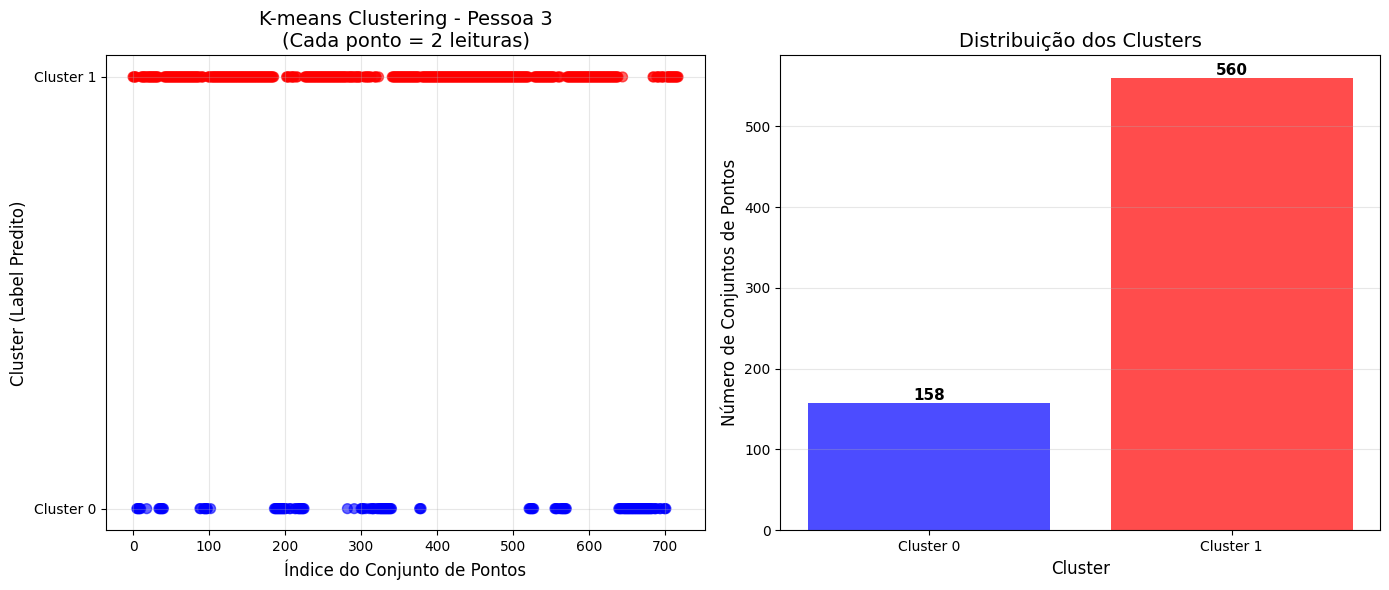


✓ Gráfico salvo como 'clustering_pessoa_3.png'

ESTATÍSTICAS
Cluster 0: 158 conjuntos (22.0%)
Cluster 1: 560 conjuntos (78.0%)

ANÁLISE CONCLUÍDA!

Para analisar todas as pessoas, descomente a última linha do script.


In [10]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print("CLUSTERIZAÇÃO K-MEANS - ACELERÔMETRO E GIROSCÓPIO")
    print("="*60)
    print(f"Taxa de amostragem: {SAMPLING_RATE}s")
    print(f"Número de clusters: {N_CLUSTERS}")
    print(f"Tamanho da janela: 2 pontos (acelerômetro + giroscópio)")
    
    # Opção 1: Analisar apenas uma pessoa (recomendado para começar)
    print("\n" + "-"*60)
    print("Opção escolhida: Analisar uma pessoa primeiro")
    print("-"*60)
    
    df_combined, features, labels, kmeans = analisar_pessoa(
        PESSOA_INICIAL, 
        window_size=2, 
        n_clusters=N_CLUSTERS
    )
    
    # Descomente a linha abaixo para analisar todas as pessoas
    # resultados = analisar_todas_pessoas(window_size=2, n_clusters=N_CLUSTERS)
    
    print("\n" + "="*60)
    print("ANÁLISE CONCLUÍDA!")
    print("="*60)
    print("\nPara analisar todas as pessoas, descomente a última linha do script.")